Author: Vincent T. Cooper  

Date: 1 December 2021  

Data preprocessing supporting the analysis in JGR Oceans manuscript submission.  

Purpose 1: Calculate the distance inside the ice edge from satellite SIC. (OLD)

Purpose 2: Use spectral tail to estimate u10 and compare with JRA reanalysis.


In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import scipy.stats as stats
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpl.path.Path(verts * radius + center)

def minorticks():
    plt.rcParams['xtick.bottom'] = True # keep my tick marks
    plt.rcParams['ytick.left'] = True

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [2]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
#     lats = iceconc_input.TLAT.values # cice version
#     lons = iceconc_input.TLON.values # cice version
    lats = iceconc_input.latitude.values # wavewatch version
    lons = iceconc_input.longitude.values # wavewatch version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point


    return(distances)

# SIC data from NOAA/NSIDC Climate Data Record (CDR)

- Preprocessing 2020 data from NSIDC
- Because of CDO problem with 2020 data when trying to regrid onto cice grid,
  we need to keep 2019 likeness but replace with 2020 values, then regrid to cice
- The cice regridding is done in terminal with CDO

In [73]:
# satdir2020 = '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/'
# sat_2020 = 'seaice_conc_daily_nh_2020_f17_v04r00.nc'
# tempsat2020 = xr.open_dataset(satdir2020 + sat_2020)

# satdir2019 = '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2019download/'
# sat_2019 = 'seaice_conc_daily_nh_2019.nc'
# tempsat2019 = xr.open_dataset(satdir2019 + sat_2019)

# tempsat2020['longitude'] = (['y','x'],tempsat2019.longitude.values)
# tempsat2020['latitude'] = (['y','x'],tempsat2019.latitude.values)
# tempsat2020 = tempsat2020.set_coords(['time','latitude','longitude'])

In [62]:
# ## manually creating 2020 dataset in likeness of 2019 dataset to enable cdo regridding
# ## and adjusting for extra leap day.
# ## Error in CDO occurring because it is recognizing the grid as something funny,
# ## even though it should be the same in the 2019 data.

# ## steps are: copy the 2019 data (365 days of it) but replace the concentration
# ## values with the 2020 data. Then replace the time variable with the 2020 times.
# ## Finally, concatenate an extra day of 12-31 because of leap year.
# ## Repeat this for each of the three concentration datasets (cdr,bt,nt).

# ## CDR
# temp = xr.DataArray(tempsat2020.cdr_seaice_conc[0:-1].values,
#               dims=tempsat2019.seaice_conc_cdr.dims,
#               coords=tempsat2019.seaice_conc_cdr.coords,
#                    name=tempsat2019.seaice_conc_cdr.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.cdr_seaice_conc[-1].values,
#               dims=tempsat2019.seaice_conc_cdr[0].dims,
#               coords=tempsat2019.seaice_conc_cdr[-1].coords,
#                          name=tempsat2019.seaice_conc_cdr.name)
# extra_day['time'] = tempsat2020.time[-1]
# cdr = xr.concat([temp,extra_day],dim='time')

# ## NT
# temp = xr.DataArray(tempsat2020.nsidc_nt_seaice_conc[0:-1].values,
#               dims=tempsat2019.goddard_nt_seaice_conc.dims,
#               coords=tempsat2019.goddard_nt_seaice_conc.coords,
#                    name=tempsat2019.goddard_nt_seaice_conc.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.nsidc_nt_seaice_conc[-1].values,
#               dims=tempsat2019.goddard_nt_seaice_conc[0].dims,
#               coords=tempsat2019.goddard_nt_seaice_conc[-1].coords,
#                          name=tempsat2019.goddard_nt_seaice_conc.name)
# extra_day['time'] = tempsat2020.time[-1]
# nt = xr.concat([temp,extra_day],dim='time')

# ## BT
# temp = xr.DataArray(tempsat2020.nsidc_bt_seaice_conc[0:-1].values,
#               dims=tempsat2019.goddard_bt_seaice_conc.dims,
#               coords=tempsat2019.goddard_bt_seaice_conc.coords,
#                    name=tempsat2019.goddard_bt_seaice_conc.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.nsidc_bt_seaice_conc[-1].values,
#               dims=tempsat2019.goddard_bt_seaice_conc[0].dims,
#               coords=tempsat2019.goddard_bt_seaice_conc[-1].coords,
#                          name=tempsat2019.goddard_bt_seaice_conc.name)
# extra_day['time'] = tempsat2020.time[-1]
# bt = xr.concat([temp,extra_day],dim='time')

# sat2020 = xr.merge([cdr,nt,bt])

In [74]:
# ## save the 2020 data on the 2019 grid details

# sat2020.to_netcdf(satdir2020 + 'seaice_conc_daily_nh_2020_ondummy2019grid.nc')
# print('finished saving')

finished saving


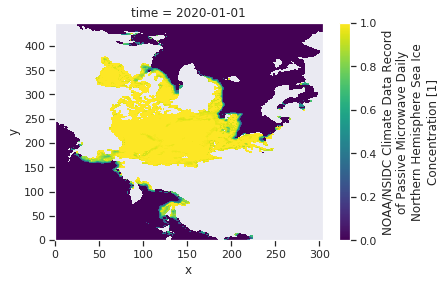

In [35]:
## add one more day onto 2019 data, then replace it with 2020

In [26]:
# tempsat2020.to_netcdf(satdir2020 + 'seaice_conc_daily_nh_2020_f17_latlon.nc')
# print('finished saving')

finished saving


In [81]:
## check regridded vs native
# xr.open_dataset('')
!ls /glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/seaice_conc_daily_nh_2020_cicegrid.nc

2019.grd
README.txt
seaice_conc_daily_nh_2020_cicegrid.nc
seaice_conc_daily_nh_2020_f17_v04r00.nc
seaice_conc_daily_nh_2020_ondummy2019grid.nc


In [ ]:
# newgrid = xr.open_dataset('/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/seaice_conc_daily_nh_2020_cicegrid.nc')

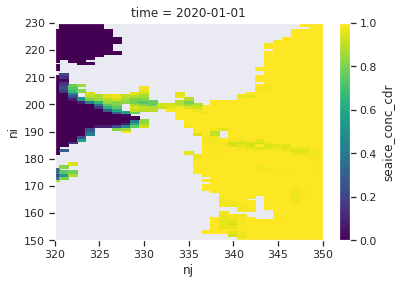

(-3000000.0, -1000000.0)

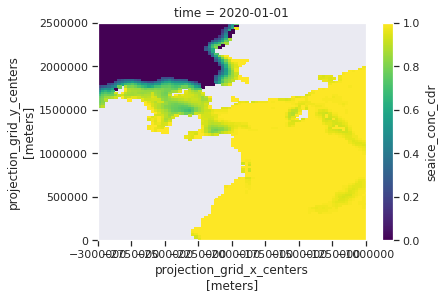

In [100]:
# newgrid.seaice_conc_cdr[0].plot(x='nj',y='ni')
# plt.xlim(320,350)
# plt.ylim(150,230)
# plt.show()

# # sat2020.seaice_conc_cdr[0].plot(x='longitude',y='latitude')
# sat2020.seaice_conc_cdr[0].plot()
# plt.ylim(0,2.5e6)
# plt.xlim(-3e6,-1e6)

#### Continue using data before

In [75]:
cdr = xr.open_dataset(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/seaice_conc_daily_nh_1979-2019.nc').sel(time=slice('2012','2019'))

In [79]:
## example
isel=-85
tempice = cdr.seaice_conc_cdr[isel]
tempdist = icedistance(tempice)
tempdist = xr.DataArray(tempdist, dims = cdr.seaice_conc_cdr[isel].dims,
            coords = cdr.seaice_conc_cdr[isel].coords).rename('dist')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


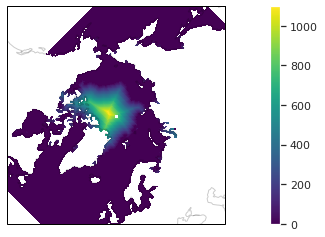

In [80]:
fig,ax = plt.subplots(1,1,figsize=(16,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
#                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=190-360)})

# plt.sca(ax[aind])
ax.coastlines(alpha=0.2,lw=1)
ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
# ax.set_extent([-174,-142,65,82], ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND)

plt.pcolormesh(cdr.longitude,cdr.latitude,
               tempdist,
               transform=ccrs.PlateCarree(),
              cmap='viridis')

plt.colorbar()
plt.show()

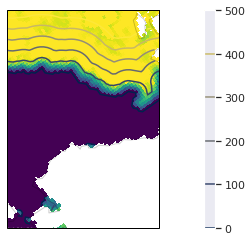

In [82]:
fig,ax = plt.subplots(1,1,figsize=(16,4),#subplot_kw={'projection': ccrs.NorthPolarStereo()})
                      subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=190-360)})

# plt.sca(ax[aind])
ax.coastlines(alpha=0.2,lw=1)
# ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
ax.set_extent([-172,-142,65,82], ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND)

plt.pcolormesh(cdr.longitude,cdr.latitude,
               cdr.seaice_conc_cdr[isel],
               transform=ccrs.PlateCarree(),
              cmap=cmo)

levset = np.arange(0,501,100)
cmapset = 'cividis'
plt.contour(cdr.longitude,cdr.latitude,
             tempdist.where(tempdist.longitude < 0),
             levels=levset,
             transform=ccrs.PlateCarree(),
             cmap=cmapset)

plt.contour(cdr.longitude,cdr.latitude,
             tempdist.where(tempdist.longitude > 0),
             levels=levset,
             transform=ccrs.PlateCarree(),
             cmap=cmapset)

plt.colorbar()
plt.show()

# Load Observations and Ice Distances

In [3]:
## reference files

# cice 2018 output because of grid with area
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)
del cice18

## NH sea ice latitudes on curvilinear grid
latslice = slice(300,384)

## revised mask for beaufort over tighter region
## old output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)
del dist_model

In [4]:
## Beaufort Sea data for 2012-2019
ww_allbeau = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc')
ww_allbeau = ww_allbeau.rename({'distance':'dist'})
## note that when we load in the the 2012-2019 dataset from the new run,
## we still keep the "ww1719" naming convention from when we only had 
## spectral output from 2017-2019. This is annoying because the '1719'
## is a misnomer, but this way the analysis code didnt need to be changed
## with the new run.
ww1719ef_beau_cat = ww_allbeau
ww1719beau_cat = ww_allbeau

## Global data as separate datasets for 2012-2019
## load and concat data 
ww2012 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc')
ww2013 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc')
ww2014 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc')
ww2015 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc')
ww2016 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc')
ww2017 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc')
ww2018 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc')
ww2019 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc')

ww_dict = {'ww2012' : ww2012,
           'ww2013' : ww2013,
           'ww2014' : ww2014,
           'ww2015' : ww2015,
           'ww2016' : ww2016,
           'ww2017' : ww2017,
           'ww2018' : ww2018,
           'ww2019' : ww2019}

temp_f = xr.open_dataset('/glade/u/home/vcooper/analysis/waveice/ww1719ef_beau_cat.nc')

for key,val in ww_dict.items():
    print(key)
    val = val.rename({'UAX': 'uwnd',
                'UAY': 'vwnd',
                'ICE': 'ice',
                'HS':  'hs',
                'T02': 't02',
                'T0M1':'t0m1',
                'T01': 't01',
                'FP0': 'fp',
                'THM': 'dir',
                'EF':  'ef',
                'FREQ':'f',
                'NX':  'ni',
                'NY':  'nj'})
    
    val['latitude'] = (['nj','ni'],grid.lat.values)
    val['longitude'] = (['nj','ni'],grid.lon.values)
    val = val.set_coords(['time','latitude','longitude'])
    val['f'] = temp_f.f
    val = val.sel(nj=latslice)
    val['tarea'] = (['nj','ni'], tarea.sel(nj=latslice).values)
    val.coords['mask'] = (('nj','ni'), beau_mask)
#     val = val.where(val.mask > 0, drop=True) ## only keep if dropping to beau
    ww_dict[key] = val
##########################################
del temp_f

ww2012
ww2013
ww2014
ww2015
ww2016
ww2017
ww2018
ww2019


In [5]:
## read in new mooring data revised by Jim Thomson Nov 2021
BGOS_dir = '/glade/campaign/univ/uwas0070/vcooper/waveice/data_jthomson/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find grid cell closest to lat lon of SWIFT obs
    templat = np.tile(da.lat.values.mean(),
                  tarea.latitude.values.size).reshape(tarea.latitude.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      tarea.longitude.values.size).reshape(tarea.longitude.values.shape) % 360
    difflat = templat - tarea.latitude.values
    difflon = templon - tarea.longitude.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

## repeat finding closest grid cell to the ob location, 
## but transform index to the reduced beaufort grid subset
nj_allbeau = {}
ni_allbeau = {}
for key,val in nj.items():
    nj_allbeau[key] = ww_allbeau.nj.where(
        ((ww_allbeau.latitude - tarea.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - tarea.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)
    ni_allbeau[key] = ww_allbeau.ni.where(
        ((ww_allbeau.latitude - tarea.latitude.sel(ni=ni[key],nj=val))**2 < 0.0000001) & 
        ((ww_allbeau.longitude - tarea.longitude.sel(ni=ni[key],nj=val))**2 < 0.0000001)).max().values.astype(int)

In [6]:
path = '/glade/campaign/univ/uwas0070/vcooper/waveice/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_2012-2020_cicegrid.nc' # name of regridded file

## this is the satellite ice conc. estimates
## I named it 'boot' because I originally thought it was the bootstrap data, but it really has
## CDR, bootstrap, and NASA team.
## CDR is used in this analysis, renamed with CICE convention for ease of code
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020.nc').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020_bt.nc').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/icedistance/' + 'sat_iceedgedistance_2012-2020_nt.nc').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt])

# ## fix grid
dist_sat_all.TLON[:] = ww_dict['ww2012'].longitude.values
dist_sat_all.TLAT[:] = ww_dict['ww2012'].latitude.values

In [7]:
%%time

## exclude the nans
sodaA = sodaA.where(sodaA.sigwaveheight > 0, drop=True)
sodaB = sodaB.where(sodaB.sigwaveheight > 0, drop=True) 
sodaC = sodaC.where(sodaC.sigwaveheight > 0, drop=True) 
bgosA = bgosA.where(bgosA.sigwaveheight > 0, drop=True) 
bgosD = bgosD.where(bgosD.sigwaveheight > 0, drop=True) 

## repeat for swifts
for i,key in enumerate(swift_dict):
    swift_dict[key] = swift_dict[key].where(swift_dict[key].sigwaveheight > 0, drop=True)

CPU times: user 2.13 s, sys: 30.1 ms, total: 2.16 s
Wall time: 2.54 s


In [8]:
%%time
# Interpolate distances to make one dataset that matches exactly the in situ obs timing.
# Then create some dictionaries for ease of acccess.
alltimes = np.array([]) # make one array of all obs times
alltimes = np.hstack((bgosA.time.values,
                      bgosD.time.values,
                      sodaA.time.values,
                      sodaB.time.values,
                      sodaC.time.values))

## add SWIFT data
for key,da in swift_dict.items():
    alltimes = np.hstack((alltimes,da.time.values))
    
alltimes = np.unique(np.sort(alltimes)) # times in ascending order, remove duplicates

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 7 ms


In [9]:
%%time
## Uncomment this line when switching back to 6 hourly resample
# dist_sat_interp = dist_sat_all.interp(time=alltimes)

## load the hourly version; comment this out when using 6 hourly
dist_sat_interp = xr.open_dataset('/glade/campaign/univ/uwas0070/vcooper/waveice/scratch_analysis/dist_sat_interp_obstimes.nc')

###### also interpolate concentrations
time_forinterp = slice('2012-01-01','2020-12-31')

boot_cdr_interptoinsitu = boot.aice_d.sel(nj=latslice,time=time_forinterp).interp(time=alltimes)

CPU times: user 18.4 s, sys: 5.26 s, total: 23.6 s
Wall time: 27.9 s


In [10]:
## create dictionary of distances at locations of obs
dist_dict = {}

## dictionaries for distance based on CDR, Boot, NASA Team, at obs locations
cdr_dict = {}
cdr_dict['bgosA'] = dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).cdr
cdr_dict['bgosD'] = dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).cdr
cdr_dict['sodaA'] = dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).cdr
cdr_dict['sodaB'] = dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).cdr
cdr_dict['sodaC'] = dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).cdr

bt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).bt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).bt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).bt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).bt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).bt}

nt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-latslice.start,ni=ni['bgosA'],time=bgosA.time).nt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-latslice.start,ni=ni['bgosD'],time=bgosD.time).nt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-latslice.start,ni=ni['sodaA'],time=sodaA.time).nt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-latslice.start,ni=ni['sodaB'],time=sodaB.time).nt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-latslice.start,ni=ni['sodaC'],time=sodaC.time).nt}

## optional addition of SWIFT data -- additional key for each buoy deployed
for key,da in swift_dict.items():
    
    ## find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  tarea.latitude.values.size).reshape(tarea.latitude.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      tarea.longitude.values.size).reshape(tarea.longitude.values.shape) + 360
    difflat = templat - tarea.latitude.values
    difflon = templon - tarea.longitude.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    
    ## insert the ice distances into the distance dictionaries
    cdr_dict[key] = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).cdr
    bt_dict[key]  = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).bt
    nt_dict[key]  = dist_sat_interp.sel(nj=njtemp-latslice.start,ni=nitemp,time=da.time).nt

dist_dict.update({'cdr' : cdr_dict,
                  'bt'  : bt_dict,
                  'nt'  : nt_dict})

# easy indexing of obs datasets
insitu_dict = {'sodaA' : sodaA,
               'sodaB' : sodaB,
               'sodaC' : sodaC,
               'bgosA' : bgosA,
               'bgosD' : bgosD,
              }

## SWIFT version already exists as swift_dict, but combine for ease with functions
for key,da in swift_dict.items():
    insitu_dict[key] = da

In [11]:
%%time

for key,val in insitu_dict.items():
    
    # let's add the CDR distance to the insitu dataset too to simplify things
    cdr = dist_dict['cdr'][key]

    # update xarray
    insitu_dict[key] = xr.merge([val,cdr])

CPU times: user 45.8 ms, sys: 864 µs, total: 46.7 ms
Wall time: 60.4 ms


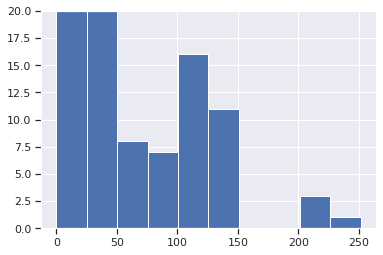

In [12]:
plt.hist(insitu_dict['sodaA'].cdr)
plt.ylim(0,20)
plt.show()

### Load JRA 55 data for wind speed

In [12]:
import copy
import dask
from glob import glob
import pickle
latslice=slice(300,384)

# temp_jra_v = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/jra55/v1.5_noleap/JRA.v1.5.v_10.TL319.2020.210504.nc')

Note: I originally loaded all JRA data then ran code to find times nearest to the desired obs. I pickled those indices to avoid loading extra data. Then I ended up just saving the reduced JRA dataset for now.

In [257]:
# jratime = jra_v.time.sel(
#     time=slice('2012-01-01','2020-12-31'))

######### PICKLING
## store data
# pkl_fname = 'jratime.pkl'
# with open(pkl_fname, 'wb') as handle:
#     pickle.dump(jratime, handle, protocol=pickle.HIGHEST_PROTOCOL)

## load data
# with open(pkl_fname, 'rb') as handle:
#     jratime = pickle.load(handle)
    
# dummy_jratime = jratime.indexes['time'].to_datetimeindex().to_numpy()
# isel_alltimes = np.searchsorted(dummy_jratime,alltimes,side='left')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [13]:
scratch_savepath = '/glade/campaign/univ/uwas0070/vcooper/waveice/scratch_analysis/'
# jra_v.sel(time=jratime[isel_alltimes]).to_netcdf(scratch_savepath + 'jra1.5_v10_2012-2020.nc')
# jra_u.sel(time=jratime[isel_alltimes]).to_netcdf(scratch_savepath + 'jra1.5_u10_2012-2020.nc')
# jra_v10 = jra_v.sel(time=jratime[isel_alltimes])
# jra_u10 = jra_u.sel(time=jratime[isel_alltimes])
jra_v10 = xr.open_dataset(scratch_savepath + 'jra1.5_v10_2012-2020.nc')
jra_u10 = xr.open_dataset(scratch_savepath + 'jra1.5_u10_2012-2020.nc')
jra_subset = xr.merge([jra_u10,jra_v10])
jra_subset['wind'] = (jra_subset.u_10**2 + jra_subset.v_10**2)**(0.5)
jra_subset['longitude'] = jra_subset.longitude

In [306]:
# ## v10
# jra_dir = '/glade/p/cesmdata/cseg/inputdata/ocn/jra55/v1.5_noleap/'
# flist = 'JRA.v1.5.v_10.TL319.20[1][2-9].210504.nc'
# flist2 = 'JRA.v1.5.v_10.TL319.2020.210504.nc'
# dfiles = sorted(glob(jra_dir + flist))
# dfiles.append(jra_dir + flist2)

# ## u10
# jra_dir = '/glade/p/cesmdata/cseg/inputdata/ocn/jra55/v1.5_noleap/'
# flist = 'JRA.v1.5.u_10.TL319.20[1][2-9].210504.nc'
# flist2 = 'JRA.v1.5.u_10.TL319.2020.210504.nc'
# dfiles = sorted(glob(jra_dir + flist))
# dfiles.append(jra_dir + flist2)
# dfiles

In [161]:
# for key,tempds in insitu_dict.items():
#     print((tempds.lon.max().values % 360).round(0))

In [287]:
# %%time

# def preprocess(ds):
#     ds = ds.sel(latitude=slice(69,78),longitude=slice(190,225))
# #     temptime = jratime[isel_alltimes].sel(time=slice(ds.time.min(),ds.time.max()))
# #     if len(temptime) == 0:
# # #         temptime = ds.time.min()
# #         ds = ds.isel(time=[1,2])
# #     else:
# #         ds = ds.sel(time=temptime)
        
#     return ds

# mfds_temp = xr.open_mfdataset(dfiles,
#                               combine='by_coords',
#                               coords='minimal',
#                               concat_dim='time',
#                               compat='override',
#                               preprocess=preprocess,
#                               parallel=False)

# # mfds_temp = mfds_temp.sel(time=isel_alltimes)
# # mfds_temp.sel(time=slice('2012-01-01','2020-12-31'))

# # jra_v = mfds_temp.load()
# jra_u = mfds_temp.load()

CPU times: user 485 ms, sys: 790 ms, total: 1.28 s
Wall time: 40.7 s


## Make dictionary of observations with relevant spectral tail params

In [18]:
## constants
Ip = 2.5 # Voermans 1.9 to 3.1 (wide to narrow), 2.5 works (Thomson 2013)
vk = 0.41 # von karman constant
g = 9.81
# beta = 0.012 #(Juszko 1995)  ## 0.012 #(Juszko 1995)
beta = 0.009

alpha = 0.012 # Charnock 1955
# or alpha below based on eq 16 in Voermans et al 2020 
# cp = g * T / (2*np.pi)
# alpha = 0.14*(ustar/cp)**0.61

In [27]:
## weird error, need to load the dataset first
insitu_dict['sodaC']

# def calcu10(spec_dict, dmin, dmax, set_Ip):
#     # feed it an empty dictionary
#     setmin = 0.3
#     Ip = set_Ip
#     freqmin = 0.06
#     for key,tempds in insitu_dict.items():
#         if ('SWIFT' not in key):
#             print(key)

#             subds = tempds.where((tempds.peakwaveperiod**(-1) > freqmin) &
#                                        (tempds.sigwaveheight > 0.3) & 
#                                        (tempds.cdr > dmin) & (tempds.cdr < dmax),drop=True)
#             if (len(subds.time) < 1):
#                 continue
                
#             spec_dict[key] = subds

#             ## get jra
#             templat = tempds.lat.values.mean()
#             templon = tempds.lon.values.mean() % 360

#             difflat = templat - jra_subset.latitude.values
#             difflon = templon - jra_subset.longitude.values
#             dlat,dlon = np.meshgrid(difflat,difflon)
#             dist = dlat**2 + dlon**2

#             lon_isel = np.where(dist == np.min(dist))[0][0]
#             lat_isel = np.where(dist == np.min(dist))[1][0]

#             jra_obstime = jra_subset.time.indexes['time'].to_datetimeindex().to_numpy()
#             jra_time_isel = np.searchsorted(jra_obstime,tempds.time)
#             tempds['jra_wind'] = ('time',
#                                   jra_subset.isel(time=jra_time_isel,
#                                                   latitude=lat_isel,
#                                                   longitude=lon_isel).wind.values)

#             spec_dict[key]['fp'] = ('time',1/spec_dict[key].peakwaveperiod)
#             spec_dict[key]['ef_eq'] = spec_dict[key].wavespectra_energy.where(
#                 (tempds.freq_wavespectra > spec_dict[key].fp) & 
#                 (tempds.freq_wavespectra > 0.2))

#             ## ef_eq forced to be above noise thresh; actually forced to be above 0.5 Hz
#             ef_eq = spec_dict[key].ef_eq
#             spec_dict[key]['cut_eq'] = spec_dict[key].ef_eq # dummy
#             tempefeq = xr.where(ef_eq < 1.5*10**(-2),tempds.freq_wavespectra,0)
#             tempefeq = xr.where(tempefeq > spec_dict[key].fp, tempefeq, 0)
#             critf = xr.where(tempefeq > 0,tempefeq.freq_wavespectra,100).min(dim='freq_wavespectra')
#     #         spec_dict[key]['cut_eq'] = ef_eq.where(critf > ef_eq.freq_wavespectra)
#             spec_dict[key]['cut_eq'] = ef_eq.where(ef_eq.freq_wavespectra < 0.4)
#             spec_dict[key]['N'] = xr.where(spec_dict[key].cut_eq > 0,1,0).sum(dim='freq_wavespectra')

#             ## wind estimates
#             spec_dict[key]['e0_mean'] = (spec_dict[key].cut_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
#     #         spec_dict[key]['e0_mean'] = (spec_dict[key].ef_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
#             ustar = spec_dict[key].e0_mean * (2*np.pi)**3 / (4 * beta * Ip * g)
#             ## special alpha
#             cp = g * spec_dict[key].peakwaveperiod / (2*np.pi)
#             alpha = 0.14*(ustar/cp)**0.61 ## special alpha eq 16 from Voermans et al 2020
#             spec_dict[key]['alpha'] = alpha
#             z0 = alpha * ustar**2 / g # + 0.11 * nu / ustar (roughness length, ignoring first term)
#             spec_dict[key]['u10est'] = ustar/vk * np.log(10 / z0)
#             spec_dict[key]['jra'] = tempds.jra_wind.sel(time=spec_dict[key].u10est.time)

#             ## RMSE
#             spec_dict[key]['rmse'] = (
#                 (spec_dict[key].ef_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
#                 dim='freq_wavespectra')**(0.5)
#             spec_dict[key]['rmse_cut'] = (
#                 (spec_dict[key].cut_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
#                 dim='freq_wavespectra')**(0.5)
#             spec_dict[key]['se'] = spec_dict[key].rmse_cut * (
#                 2*np.pi)**3 / (4 * beta * Ip * g) / vk * np.log(10 / z0) # standard error in u10 m/s terms

#             ## RMSLE
#             p = spec_dict[key]['e0_mean'] # prediction
#             a = spec_dict[key].ef_eq * tempds.freq_wavespectra**4 # actual
#             a_cut = spec_dict[key].cut_eq * tempds.freq_wavespectra**4 # actual
#             spec_dict[key]['rmsle'] = (
#                 (np.log(p + 1) - np.log(a + 1))**2).mean(dim='freq_wavespectra')**(0.5)
#             spec_dict[key]['rmsle_cut'] = (
#                 (np.log(p + 1) - np.log(a_cut + 1))**2).mean(dim='freq_wavespectra')**(0.5)
            
#             spec_dict[key]['obname'] = xr.DataArray(np.tile([key],len(ustar.time)), 
#                                 dims=subds.time.dims, coords = subds.time.coords)
            
#     return(spec_dict)

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 85, time: 20)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.9941
  * time                (time) datetime64[ns] 2019-07-20T22:00:00 ... 2019-09...
    TLON                (time) float32 220.5828 220.5828 ... 220.5828 220.5828
    TLAT                (time) float32 78.022224 78.022224 ... 78.022224
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 0.0 0.0 0.0 ... nan nan
    wavespectra_a1      (time, freq_wavespectra) float64 0.06227 ... -0.1196
    wavespectra_b1      (time, freq_wavespectra) float64 -0.2679 ... -0.1517
    wavespectra_a2      (time, freq_wavespectra) float64 -0.2692 ... 0.07814
    wavespectra_b2      (time, freq_wavespectra) float64 -0.2918 ... 0.142
    wavespectra_check   (time, freq_wavespectra) float64 107.8 60.35 ... 0.06249
    lat                 (time) float64 77.74 77.74 77.74 ... 77.74 77.74 77.74
    lon                 (time) float64 -139.1 -139.1 -139.1 ... -139.1 -139.1
    sigwaveheight       (time) float64 0.3325 0.363 0.3417 ... 0.3511 0.3228
    peakwaveperiod      (time) float64 2.04 2.255 1.862 ... 2.04 2.04 1.679
    peakwavedirT        (time) float64 297.0 217.9 nan nan ... 328.0 nan nan
    cdr                 (time) float64 475.8 474.1 474.1 ... 215.0 213.9 147.8

In [674]:
def calcu10(spec_dict, dmin, dmax, set_Ip):
    # feed it an empty dictionary
    setmin = 0.3
    Ip = set_Ip
    fpmin = 0.06
    Nlim = 10
    
    for key,tempds in insitu_dict.items():
        if ('SWIFT' not in key):
            print(key)

            subds = tempds.where((tempds.peakwaveperiod**(-1) > fpmin) &
                                       (tempds.sigwaveheight > 0.3) & 
                                       (tempds.cdr > dmin) & (tempds.cdr < dmax),drop=True)
            if (len(subds.time) < 1):
                continue
                
            spec_dict[key] = subds

            ## get jra
            templat = tempds.lat.values.mean()
            templon = tempds.lon.values.mean() % 360

            difflat = templat - jra_subset.latitude.values
            difflon = templon - jra_subset.longitude.values
            dlat,dlon = np.meshgrid(difflat,difflon)
            dist = dlat**2 + dlon**2

            lon_isel = np.where(dist == np.min(dist))[0][0]
            lat_isel = np.where(dist == np.min(dist))[1][0]

            jra_obstime = jra_subset.time.indexes['time'].to_datetimeindex().to_numpy()
            jra_time_isel = np.searchsorted(jra_obstime,tempds.time)
            tempds['jra_wind'] = ('time',
                                  jra_subset.isel(time=jra_time_isel,
                                                  latitude=lat_isel,
                                                  longitude=lon_isel).wind.values)

            spec_dict[key]['fp'] = ('time',1/spec_dict[key].peakwaveperiod)
            spec_dict[key]['ef_eq'] = spec_dict[key].wavespectra_energy.where(
                (tempds.freq_wavespectra > spec_dict[key].fp) & 
                (tempds.freq_wavespectra > 0.2))

            ## ef_eq forced to be above noise thresh; actually forced to be above 0.5 Hz
            ef_eq = spec_dict[key].ef_eq
            spec_dict[key]['cut_eq'] = spec_dict[key].ef_eq # dummy
            tempefeq = xr.where(ef_eq < 1.5*10**(-2),tempds.freq_wavespectra,0)
            tempefeq = xr.where(tempefeq > spec_dict[key].fp, tempefeq, 0)
            critf = xr.where(tempefeq > 0,tempefeq.freq_wavespectra,100).min(dim='freq_wavespectra')
    #         spec_dict[key]['cut_eq'] = ef_eq.where(critf > ef_eq.freq_wavespectra)
            spec_dict[key]['cut_eq'] = ef_eq.where(ef_eq.freq_wavespectra < 0.5)
            spec_dict[key]['N'] = xr.where(spec_dict[key].cut_eq > 0,1,0).sum(dim='freq_wavespectra')

            #### make multiple e0means starting at each N ## can cut this out if I want
            subds = spec_dict[key]
            Nchecklimit = 20
            Nchecks = subds.N.values - Nchecklimit + 1
            Nchecks = np.where(Nchecks > 0, Nchecks, 0)
            fstart_isel = xr.where(
                subds.cut_eq > 0,subds.freq_wavespectra,100).argmin(dim='freq_wavespectra')
            for i,val in enumerate(Nchecks):
                if val < 2:
                    continue

                hold_i = np.arange(fstart_isel.values[i],
                                   fstart_isel.values[i]+Nchecklimit,1)[np.newaxis,:].repeat(val,axis=0)
                hold_i += np.arange(0,val,1)[:,np.newaxis].repeat(Nchecklimit,axis=1)

                hold_f = subds.freq_wavespectra.values[hold_i.ravel()].reshape(hold_i.shape)
                hold_ef = subds.wavespectra_energy[i].values[hold_i.ravel()].reshape(hold_i.shape)
                hold_prod = hold_ef * hold_f**4
                hold_e0 = np.mean(hold_prod,axis=1)
                hold_se = np.mean((hold_prod - hold_e0[:,np.newaxis])**2,axis=1)**(0.5)
                f_nlim = hold_f[hold_se.argmin()]

                spec_dict[key].cut_eq[i] = subds.cut_eq[i].where(
                    subds.freq_wavespectra.isin(f_nlim))
            
            ## wind estimates
            spec_dict[key]['e0_mean'] = (spec_dict[key].cut_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
    #         spec_dict[key]['e0_mean'] = (spec_dict[key].ef_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')
            ustar = spec_dict[key].e0_mean * (2*np.pi)**3 / (4 * beta * Ip * g)
            ## special alpha
            cp = g * spec_dict[key].peakwaveperiod / (2*np.pi)
            alpha = 0.14*(ustar/cp)**0.61 ## special alpha eq 16 from Voermans et al 2020
            spec_dict[key]['alpha'] = alpha
            z0 = alpha * ustar**2 / g # + 0.11 * nu / ustar (roughness length, ignoring first term)
            spec_dict[key]['u10est'] = ustar/vk * np.log(10 / z0)
            spec_dict[key]['jra'] = tempds.jra_wind.sel(time=spec_dict[key].u10est.time)

            ## RMSE
            spec_dict[key]['rmse'] = (
                (spec_dict[key].ef_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
                dim='freq_wavespectra')**(0.5)
            spec_dict[key]['rmse_cut'] = (
                (spec_dict[key].cut_eq * tempds.freq_wavespectra**4 - spec_dict[key]['e0_mean'])**2).mean(
                dim='freq_wavespectra')**(0.5)
            spec_dict[key]['se'] = spec_dict[key].rmse_cut * (
                2*np.pi)**3 / (4 * beta * Ip * g) / vk * np.log(10 / z0) # standard error in u10 m/s terms

            ## RMSLE
            p = spec_dict[key]['e0_mean'] # prediction
            a = spec_dict[key].ef_eq * tempds.freq_wavespectra**4 # actual
            a_cut = spec_dict[key].cut_eq * tempds.freq_wavespectra**4 # actual
            spec_dict[key]['rmsle'] = (
                (np.log(p + 1) - np.log(a + 1))**2).mean(dim='freq_wavespectra')**(0.5)
            spec_dict[key]['rmsle_cut'] = (
                (np.log(p + 1) - np.log(a_cut + 1))**2).mean(dim='freq_wavespectra')**(0.5)
            
            spec_dict[key]['obname'] = xr.DataArray(np.tile([key],len(ustar.time)), 
                                dims=subds.time.dims, coords = subds.time.coords)
            
    return(spec_dict)

In [545]:
# key='sodaB'
# subds = spec_d[key]
# # e0means = np.zeros([spec_d[key].N,])
# Nlim = 10
# Nchecks = spec_d[key].N.values - Nlim + 1
# Nchecks = np.where(Nchecks > 0, Nchecks, 0)
# # e0means = np.ones([len(subds.N), Nchecks.max()])*1e3

# # (spec_dict[key].cut_eq * tempds.freq_wavespectra**4).mean(dim='freq_wavespectra')

# fstart_isel = xr.where(subds.cut_eq > 0,subds.freq_wavespectra,100).argmin(dim='freq_wavespectra')

# # for i in range(Nchecks.max()):
# #     e0means[:,i] = 
    
# # (subds.cut_eq * subds.freq_wavespectra**4).values[:,fstart_isel.values:fstart_isel.values + Nlim]
# # (subds.cut_eq * subds.freq_wavespectra**4).values.shape
# # fstart_isel.values + Nlim


# for i,val in enumerate(Nchecks[0:3]):
#     if val < 2:
#         continue
    
#     hold_i = np.arange(fstart_isel.values[i],fstart_isel.values[i]+Nlim,1)[np.newaxis,:].repeat(val,axis=0)
#     hold_i += np.arange(0,val,1)[:,np.newaxis].repeat(Nlim,axis=1)

#     hold_f = subds.freq_wavespectra.values[hold_i.ravel()].reshape(hold_i.shape)
#     hold_ef = subds.wavespectra_energy[i].values[hold_i.ravel()].reshape(hold_i.shape)
#     hold_prod = hold_ef * hold_f**4
#     hold_e0 = np.mean(hold_prod,axis=1)
#     hold_se = np.mean((hold_prod - hold_e0[:,np.newaxis])**2,axis=1)**(0.5)
#     f_nlim = hold_f[hold_se.argmin()]
    
#     subds.cut_eq[i] = subds.cut_eq[i].where(subds.freq_wavespectra.isin(f_nlim))

    
# # i=0
# # val=Nchecks[i]

# # hold_i = np.arange(fstart_isel.values[i],fstart_isel.values[i]+Nlim,1)[np.newaxis,:].repeat(val,axis=0)
# # hold_i += np.arange(0,val,1)[:,np.newaxis].repeat(Nlim,axis=1)

# # hold_f = subds.freq_wavespectra.values[hold_i.ravel()].reshape(hold_i.shape)
# # hold_ef = subds.wavespectra_energy[i].values[hold_i.ravel()].reshape(hold_i.shape)
# # hold_prod = hold_ef * hold_f**4
# # hold_e0 = np.mean(hold_prod,axis=1)
# # hold_se = np.mean((hold_prod - hold_e0[:,np.newaxis])**2,axis=1)**(0.5)
# # hold_se.argmin()

# # # subds.cut_eq[0].where(subds.freq_wavespectra in hold_f[hold_se.argmin()])
# # hold_f[hold_se.argmin()]

# # # plt.plot(hold_se)

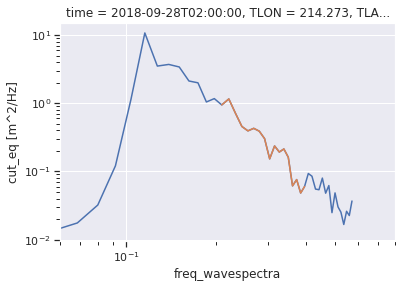

In [544]:
subds.wavespectra_energy[1].plot()
subds.cut_eq[1].plot()
plt.loglog()
plt.xlim(0.06,0.8)
plt.show()

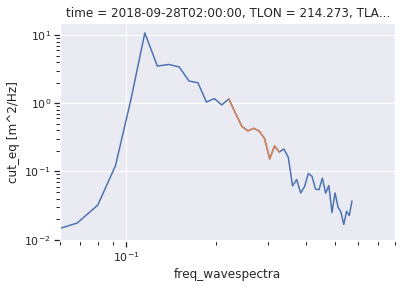

In [676]:
subds.wavespectra_energy[1].plot()
subds.cut_eq[1].plot()
plt.loglog()
plt.xlim(0.06,0.8)
plt.show()

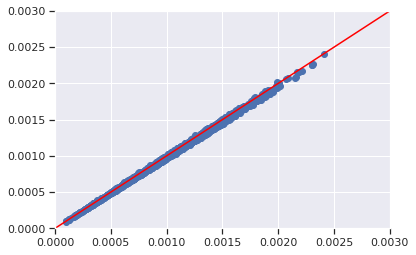

In [151]:
## quick check with Suneil mean equation to make sure I have right numbers
## looks like error on integration vs straight mean is trivial
fmin = spec_d['bgosA'].freq_wavespectra.where(spec_d['bgosA'].cut_eq > 0).min(dim='freq_wavespectra')
fmax = spec_d['bgosA'].freq_wavespectra.where(spec_d['bgosA'].cut_eq > 0).max(dim='freq_wavespectra')

Ip=2.5
c_all = (2*np.pi)**3 / (4 * beta * Ip * g)
integrand = (spec_d['bgosA'].cut_eq * spec_d['bgosA'].freq_wavespectra**4 / (fmax-fmin)).fillna(0)
plt.scatter(integrand.integrate('freq_wavespectra'),spec_d['bgosA'].e0_mean)
plt.xlim(0,0.003)
plt.ylim(0,0.003)
plt.plot([0,1],[0,1],c='r')

In [675]:
%%time
spec_d = {}
spec_d_open = {}
spec_d_open = calcu10(spec_d_open,-1,0.1,2.5)
spec_d = spec_d_open

spec_d_100 = {}
spec_d_100 = calcu10(spec_d_100,100,1e6,1.9)

sodaA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaB


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaC
bgosA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


bgosD


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaB


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


sodaC
bgosA


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


bgosD
CPU times: user 26.5 s, sys: 2.06 s, total: 28.6 s
Wall time: 30.1 s


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [688]:
spec_d = spec_d_100

In [673]:
for i,val in spec_d_100.items():
    print(val.N.max())

<xarray.DataArray 'N' ()>
array(17)
<xarray.DataArray 'N' ()>
array(7)
<xarray.DataArray 'N' ()>
array(11)
<xarray.DataArray 'N' ()>
array(25)
<xarray.DataArray 'N' ()>
array(20)


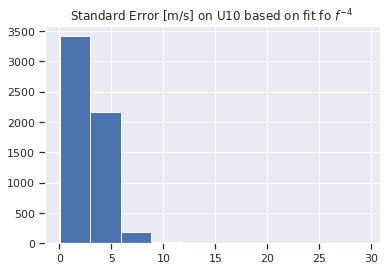

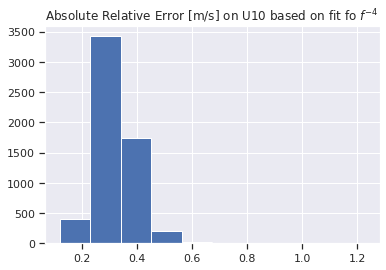

In [224]:
plt.title('Standard Error [m/s] on U10 based on fit fo $f^{-4}$')
plt.hist(spec_d_open['bgosA'].se)
plt.show()

plt.title('Absolute Relative Error [m/s] on U10 based on fit fo $f^{-4}$')
plt.hist(spec_d_open['bgosA'].se / spec_d_open['bgosA'].u10est)
plt.show()

[]

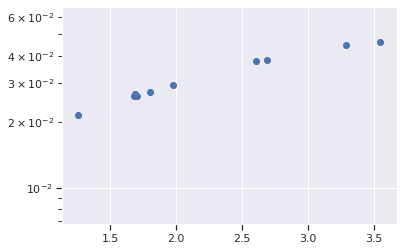

In [52]:
spec_sel = spec_d['sodaA']
plt.scatter(spec_sel.u10est/(spec_sel.peakwaveperiod*g/2/np.pi), spec_sel.alpha)
plt.semilogy()

In [677]:
## f-4 line
Ax = np.linspace(0.3,0.55,20)
AA = 1/(0.3**-4)
Ay = AA * Ax **(-4)

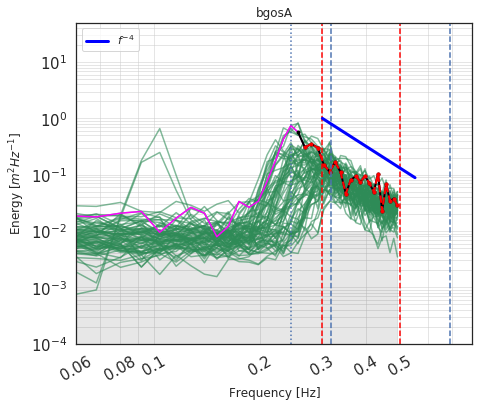

In [691]:
obkey = 'bgosA'
spec = spec_d[obkey]
time_isel = -10
spec_sel = spec.isel(time=time_isel)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod
ef_eq = spec.ef_eq

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.plot.line(
        hue='time',alpha=0.6,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')
    
    ## selected spectra
    spec_sel.wavespectra_energy.plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    
    ef_eq.isel(time=time_isel).plot(xscale='log',yscale='log',
        c='k',lw=2,marker='.')
    spec_sel.cut_eq.plot(xscale='log',yscale='log',
        c='r',lw=2,marker='.',ls='--')
#     ef_eq[0].where(ef_eq.freq_wavespectra < tempefeq[0][critf[0]]).plot(xscale='log',yscale='log',
#         c='b',lw=2,marker='.')
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='dotted')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.plot(Ax,Ay,label='$f^{-4}$',lw=3,c='b')
    plt.legend()
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.8)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(obkey)
    
    fig.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


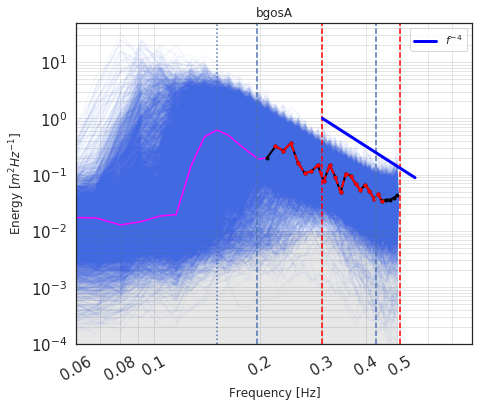

In [669]:
obkey = 'bgosA'
spec = spec_d_open[obkey]
time_isel = -12
spec_sel = spec.isel(time=time_isel)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod
ef_eq = spec.ef_eq

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.plot.line(
        hue='time',alpha=0.05,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')
    
    ## selected spectra
    spec_sel.wavespectra_energy.plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    
    ef_eq.isel(time=time_isel).plot(xscale='log',yscale='log',
        c='k',lw=2,marker='.')
    spec_sel.cut_eq.plot(xscale='log',yscale='log',
        c='r',lw=2,marker='.',ls='--')
#     ef_eq[0].where(ef_eq.freq_wavespectra < tempefeq[0][critf[0]]).plot(xscale='log',yscale='log',
#         c='b',lw=2,marker='.')
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='dotted')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.plot(Ax,Ay,label='$f^{-4}$',lw=3,c='b')
#     plt.legend()
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.8)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(obkey)
    
    fig.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


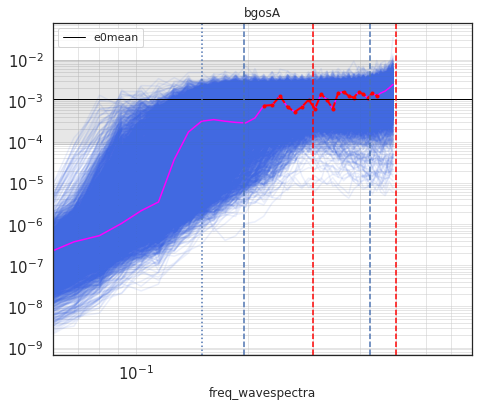

In [670]:
obkey = 'bgosA'
spec = spec_d_open[obkey]
time_isel = -12
spec_sel = spec.isel(time=time_isel)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod
ef_eq = spec.ef_eq

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    (spec.wavespectra_energy * spec.freq_wavespectra**4).plot.line(
        hue='time',alpha=0.1,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')
    
    ## selected spectra
    (spec_sel.wavespectra_energy * spec_sel.freq_wavespectra**4).plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    
    (spec_sel.cut_eq * spec_sel.freq_wavespectra**4).plot(xscale='log',yscale='log',
        c='r',lw=2,marker='.',ls='--')
    plt.axhline(spec_sel.e0_mean,c='k',lw=1,label='e0mean')
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='dotted')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.plot(xx,yy,label='$f^{-4}$',lw=3,c='b')
    plt.legend()
    
#     xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
#     plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
#     plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.8)
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]')
#     plt.xlabel('Frequency [Hz]')
    plt.title(obkey)
    
    fig.tight_layout()
    plt.show()

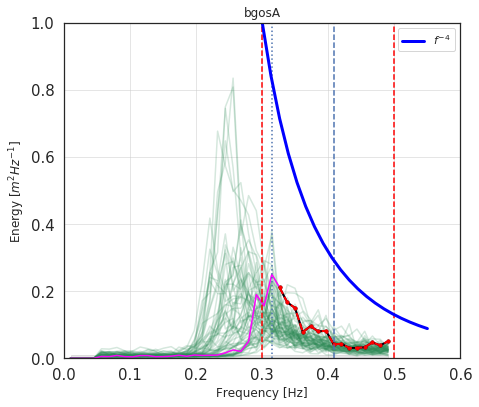

In [43]:
obkey = 'bgosA'
spec = spec_d[obkey]
time_isel = -10
spec_sel = spec.isel(time=time_isel)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod
ef_eq = spec.ef_eq

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.plot.line(
        hue='time',alpha=0.2,add_legend=False,
#         xscale='log',yscale='log',
        c='seagreen')
    
    ## selected spectra
    spec_sel.wavespectra_energy.plot(alpha=0.99,
#         xscale='log',yscale='log',
        c='magenta')
    
    ef_eq.isel(time=time_isel).plot(#xscale='log',yscale='log',
        c='k',lw=2,marker='.')
    spec_sel.cut_eq.plot(#xscale='log',yscale='log',
        c='r',lw=2,marker='.',ls='--')
#     ef_eq[0].where(ef_eq.freq_wavespectra < tempefeq[0][critf[0]]).plot(xscale='log',yscale='log',
#         c='b',lw=2,marker='.')
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='dotted')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.plot(xx,yy,label='$f^{-4}$',lw=3,c='b')
    plt.legend()
    
#     xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
#     plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(0,1)
    plt.xlim(0,0.6)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(obkey)
    
    fig.tight_layout()
    plt.show()

sodaA 10
sodaB 1
sodaC 11
bgosA 68
bgosD 6


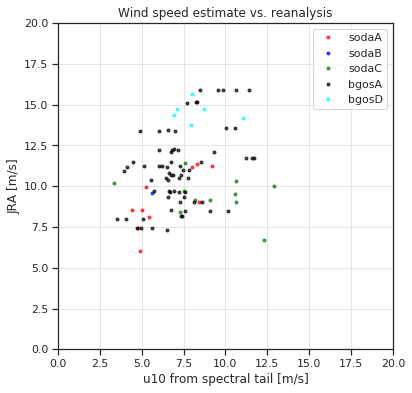

In [85]:
clist = ['r','b','g','k','cyan']
i=0

Nlim = 0

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.7,c=clist[i],label=key)
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 6
sodaB 0
sodaC 2
bgosA 68
bgosD 6


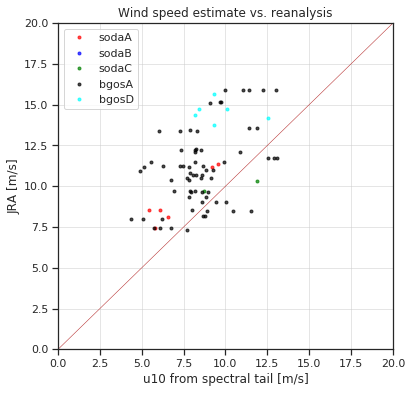

In [142]:
clist = ['r','b','g','k','cyan']
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.7,c=clist[i],label=key)
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 6
sodaB 0
sodaC 2
bgosA 68
bgosD 6


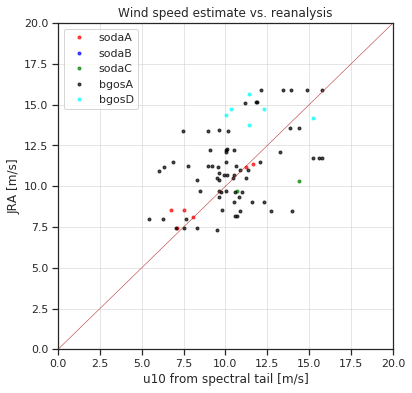

In [70]:
clist = ['r','b','g','k','cyan']
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.7,c=clist[i],label=key)
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 6
sodaB 0
sodaC 2
bgosA 70
bgosD 6


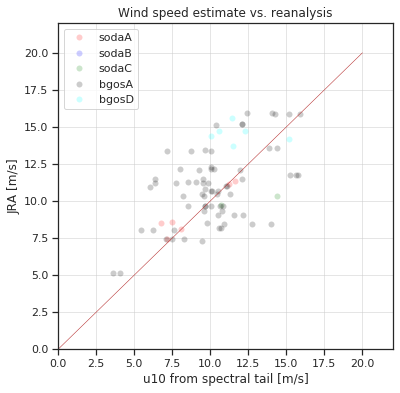

In [692]:
clist = ['r','b','g','k','cyan']
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='o',alpha=0.2,mec='none',c=clist[i],label=key)
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,22)
    plt.xlim(0,22)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 361
sodaB 110
bgosA 1614
bgosD 1083
sodaA 6
sodaB 0
sodaC 2
bgosA 68
bgosD 6


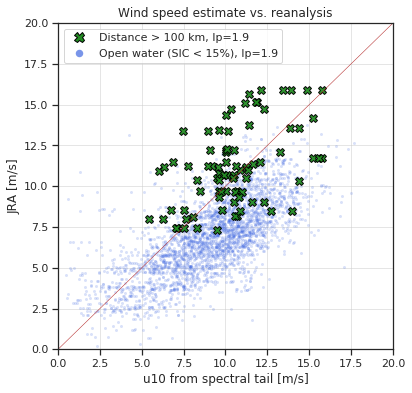

In [185]:
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d_open.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.2,mec='none',c='royalblue')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1
        
    for key,tempds in spec_d_100.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),ms=8,
                 ls='',marker='X',alpha=0.95,mec='k',c='forestgreen')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    # dummy labels
    plt.plot(-1,-1,ls='',marker='X',ms=10,
             alpha=1,mec='k',c='forestgreen',label='Distance > 100 km, Ip=1.9')
    plt.plot(-1,-1,ls='',marker='.',ms=15,
             alpha=0.7,mec='none',c='royalblue',label='Open water (SIC < 15%), Ip=1.9')
    
    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 361
sodaB 110
bgosA 1614
bgosD 1083
sodaA 6
sodaB 0
sodaC 2
bgosA 68
bgosD 6


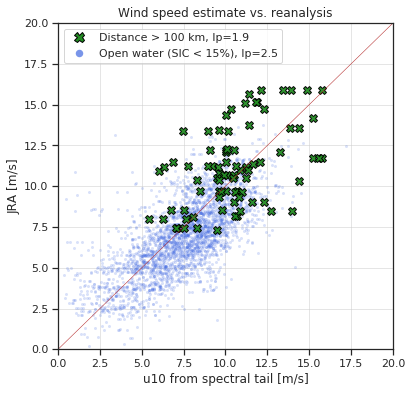

In [188]:
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d_open.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.2,mec='none',c='royalblue')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1
        
    for key,tempds in spec_d_100.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),ms=8,
                 ls='',marker='X',alpha=0.95,mec='k',c='forestgreen')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    # dummy labels
    plt.plot(-1,-1,ls='',marker='X',ms=10,
             alpha=1,mec='k',c='forestgreen',label='Distance > 100 km, Ip=1.9')
    plt.plot(-1,-1,ls='',marker='.',ms=15,
             alpha=0.7,mec='none',c='royalblue',label='Open water (SIC < 15%), Ip=2.5')
    
    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('u10 from spectral tail [m/s]')
    plt.ylabel('JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

sodaA 1082
sodaB 295
bgosA 5796
bgosD 2481
sodaA 6
sodaB 0
sodaC 2
bgosA 70
bgosD 6


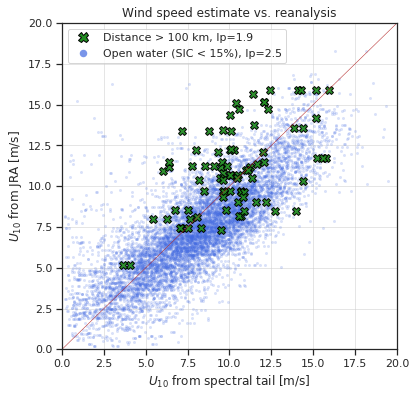

In [678]:
i=0

Nlim = 10

with sns.axes_style('ticks'):
    plt.figure(figsize=(6,6))

    for key,tempds in spec_d_open.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),
                 ls='',marker='.',alpha=0.2,mec='none',c='royalblue')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1
        
    for key,tempds in spec_d_100.items():
        plt.plot(tempds.u10est.where(tempds.N >= Nlim),
                 tempds.jra.where(tempds.N >= Nlim),ms=8,
                 ls='',marker='X',alpha=0.95,mec='k',c='forestgreen')
        nptemp = tempds.u10est.where(tempds.N >= Nlim).values
        nptemp = nptemp[~np.isnan(nptemp)]
        print(key,len(nptemp))
        i+=1

    # dummy labels
    plt.plot(-1,-1,ls='',marker='X',ms=10,
             alpha=1,mec='k',c='forestgreen',label='Distance > 100 km, Ip=1.9')
    plt.plot(-1,-1,ls='',marker='.',ms=15,
             alpha=0.7,mec='none',c='royalblue',label='Open water (SIC < 15%), Ip=2.5')
    
    plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='firebrick',lw=0.5)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('$U_{10}$ from spectral tail [m/s]')
    plt.ylabel('$U_{10}$ from JRA [m/s]')
    plt.ylim(0,20)
    plt.xlim(0,20)
    plt.title('Wind speed estimate vs. reanalysis')
    plt.show()

In [693]:
u10_all = np.array([])
jra_all = np.array([])
rmse_all = np.array([])
rmsecut_all = np.array([])

for key,tempds in spec_d.items():
#     if key != 'sodaC':
    u10_all = np.append(u10_all,tempds.u10est.where(tempds.N >= Nlim))
    jra_all = np.append(jra_all,tempds.jra.where(tempds.N >= Nlim))
    rmse_all = np.append(rmse_all,tempds.rmse.where(tempds.N >= Nlim))
    rmsecut_all = np.append(rmsecut_all,tempds.rmse_cut.where(tempds.N >= Nlim))
        
jra_all = jra_all[~np.isnan(u10_all)]
rmse_all = rmse_all[~np.isnan(u10_all)]
rmsecut_all = rmsecut_all[~np.isnan(u10_all)]
u10_all = u10_all[~np.isnan(u10_all)]

In [694]:
varlist = ['sigwaveheight','fp','cdr','u10est','jra','e0_mean','rmse_cut','rmsle_cut','N','obname']

bulk_ds = xr.concat([spec_d['sodaA'][varlist], 
           spec_d['sodaB'][varlist],
#            spec_d['sodaC'][varlist],
           spec_d['bgosA'][varlist],
           spec_d['bgosD'][varlist]],dim='time')
bulk_ds = bulk_ds.where(bulk_ds.N >= Nlim)
bulk_ds = bulk_ds.set_coords('obname')
bulk_ds = bulk_ds.where(~np.isnan(bulk_ds.u10est),drop=True)
bulk_ds['err'] = bulk_ds.u10est - bulk_ds.jra

# bulk_ds_open = xr.concat([spec_d['sodaA'][varlist], 
#            spec_d['sodaB'][varlist],
#            spec_d['sodaC'][varlist],
#            spec_d['bgosA'][varlist],
#            spec_d['bgosD'][varlist]],dim='time')

In [681]:
res = stats.linregress(u10_all,jra_all)

## RMSE for less than 12 m/s
wmin = 12
print(np.sqrt(np.mean((u10_all[jra_all < wmin] - jra_all[jra_all < wmin])**2)))

## relative abs error
wmin = 10
np.abs((u10_all[jra_all > wmin] - jra_all[jra_all > wmin])/jra_all[jra_all > wmin]).mean()

2.1992752590287292


0.16376637193372304

In [576]:
res = stats.linregress(bulk_ds.u10est,bulk_ds.jra)

## RMSE for less than 12 m/s
wmin = 12
print(np.sqrt(np.mean((bulk_ds.u10est.values[bulk_ds.jra.values < wmin] - bulk_ds.jra.values[bulk_ds.jra.values < wmin])**2)))

## relative abs error
wmin = 10
np.abs(
    (bulk_ds.u10est.values[bulk_ds.jra.values > wmin] - bulk_ds.jra.values[bulk_ds.jra.values > wmin])/bulk_ds.jra.values[bulk_ds.jra.values > wmin]).mean()

2.2229669559438583


0.17292189061173158

In [695]:
res = stats.linregress(bulk_ds.u10est,bulk_ds.jra)

## RMSE for less than 12 m/s
wmin = 12
print(np.sqrt(np.mean((bulk_ds.u10est.values[bulk_ds.jra.values < wmin] - bulk_ds.jra.values[bulk_ds.jra.values < wmin])**2)))

## relative abs error
wmin = 10
np.abs(
    (bulk_ds.u10est.values[bulk_ds.jra.values > wmin] - bulk_ds.jra.values[bulk_ds.jra.values > wmin])/bulk_ds.jra.values[bulk_ds.jra.values > wmin]).mean()

2.2166539182917737


0.17825262070694242

In [682]:
res = stats.linregress(u10_all,jra_all)

## RMSE for less than 12 m/s
wmin = 12
jra_rmse = np.sqrt(np.mean((u10_all[jra_all < wmin] - jra_all[jra_all < wmin])**2))
print('RMSE for winds less than 12 m/s: ' + str(jra_rmse.round(2)) + ' m/s')

## relative abs error
wmin = 10
jra_relerr = np.abs((u10_all[jra_all > wmin] - jra_all[jra_all > wmin])/jra_all[jra_all > wmin]).mean()
print('Relative error for winds greater than 10 m/s: ' + str(((jra_relerr*100)).round(1))+ '%')

RMSE for winds less than 12 m/s: 2.2 m/s
Relative error for winds greater than 10 m/s: 16.4%


In [696]:
res = stats.linregress(u10_all,jra_all)

## RMSE for less than 12 m/s
wmin = 12
jra_rmse = np.sqrt(np.mean((u10_all[jra_all < wmin] - jra_all[jra_all < wmin])**2))
print('RMSE for winds less than 12 m/s: ' + str(jra_rmse.round(2)) + ' m/s')

## relative abs error
wmin = 10
jra_relerr = np.abs((u10_all[jra_all > wmin] - jra_all[jra_all > wmin])/jra_all[jra_all > wmin]).mean()
print('Relative error for winds greater than 10 m/s: ' + str(((jra_relerr*100)).round(1))+ '%')

RMSE for winds less than 12 m/s: 2.25 m/s
Relative error for winds greater than 10 m/s: 18.2%


In [64]:
res = stats.linregress(u10_all,jra_all)

## RMSE for less than 12 m/s
wmin = 12
jra_rmse = np.sqrt(np.mean((u10_all[jra_all < wmin] - jra_all[jra_all < wmin])**2))
print('RMSE for winds less than 12 m/s: ' + str(jra_rmse.round(2)) + ' m/s')

## relative abs error
wmin = 10
jra_relerr = np.abs((u10_all[jra_all > wmin] - jra_all[jra_all > wmin])/jra_all[jra_all > wmin]).mean()
print('Relative error for winds greater than 10 m/s: ' + str(jra_relerr.round(3)*100)+ '%')

RMSE for winds less than 12 m/s: 2.23 m/s
Relative error for winds greater than 10 m/s: 17.9%


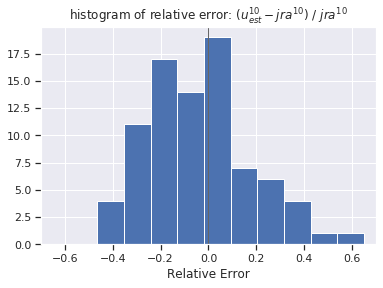

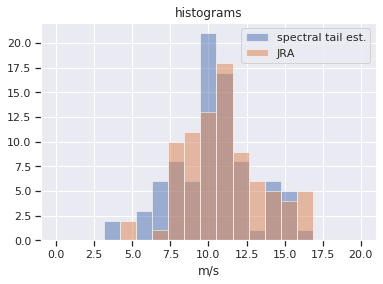

In [702]:
plt.hist((u10_all - jra_all)/jra_all,bins=10)
plt.xlim(-0.7,0.7)
plt.axvline(0,c='0.4',lw=1)
plt.xlabel('Relative Error')
plt.title('histogram of relative error: $(u^{10}_{est} - jra^{10} ) \ / \  jra^{10}$')
plt.show()

plt.title('histograms')
plt.hist(u10_all,alpha=0.5,bins = np.linspace(0,20,20),label='spectral tail est.')
plt.hist(jra_all,alpha=0.5,bins = np.linspace(0,20,20),label= 'JRA')
plt.legend()
plt.xlabel('m/s')
plt.show()

In [67]:
plt.hist?

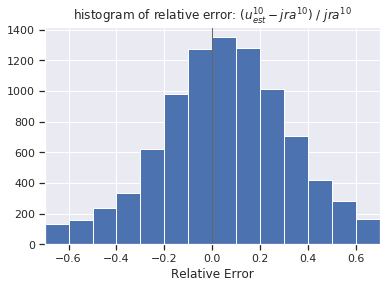

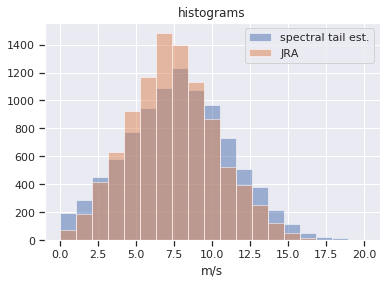

In [578]:
## open water
plt.hist((u10_all - jra_all)/jra_all,range=[-1,1],bins=20)
plt.xlim(-0.7,0.7)
plt.axvline(0,c='0.4',lw=1)
plt.xlabel('Relative Error')
plt.title('histogram of relative error: $(u^{10}_{est} - jra^{10} ) \ / \  jra^{10}$')
plt.show()

plt.title('histograms')
plt.hist(u10_all,alpha=0.5,bins = np.linspace(0,20,20),label='spectral tail est.')
plt.hist(jra_all,alpha=0.5,bins = np.linspace(0,20,20),label= 'JRA')
plt.legend()
plt.xlabel('m/s')
plt.show()

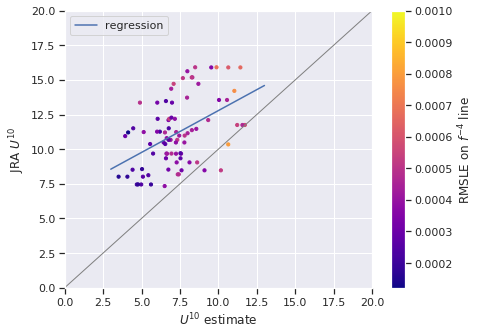

In [41]:
plt.figure(figsize=(7,5))
xx = np.linspace(3,13,100)
# plt.plot(u10_all,jra_all,marker='.',ls='')
plt.scatter(bulk_ds.u10est, bulk_ds.jra_wind, c=bulk_ds.rmsle_cut, s=10, cmap='plasma',vmax=1e-3)
plt.colorbar(label='RMSLE on $f^{-4}$ line')
plt.plot(xx,xx*res.slope + res.intercept,label='regression')
plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='0.5',lw=1)
plt.legend()
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('$U^{10}$ estimate')
plt.ylabel('JRA $U^{10}$')
plt.tight_layout()
plt.show()

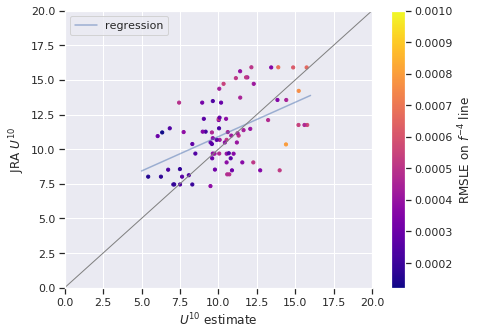

In [67]:
plt.figure(figsize=(7,5))
xx = np.linspace(5,16,100)
# plt.plot(u10_all,jra_all,marker='.',ls='')
plt.scatter(bulk_ds.u10est, bulk_ds.jra_wind, c=bulk_ds.rmsle_cut, s=10, cmap='plasma',vmax=1e-3)
plt.colorbar(label='RMSLE on $f^{-4}$ line')
plt.plot(xx,xx*res.slope + res.intercept,alpha=0.5,label='regression')
plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='0.5',lw=1)
plt.legend()
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('$U^{10}$ estimate')
plt.ylabel('JRA $U^{10}$')
plt.tight_layout()
plt.show()

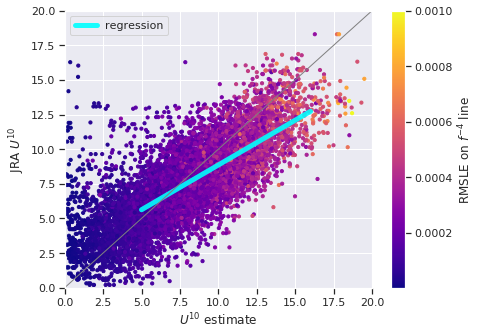

In [581]:
plt.figure(figsize=(7,5))
xx = np.linspace(5,16,100)
# plt.plot(u10_all,jra_all,marker='.',ls='')
plt.scatter(bulk_ds.u10est, bulk_ds.jra, c=bulk_ds.rmse_cut, s=10, cmap='plasma',vmax=1e-3)
plt.colorbar(label='RMSLE on $f^{-4}$ line')
plt.plot(xx,xx*res.slope + res.intercept,alpha=0.9,label='regression',lw=5,c='cyan')
plt.plot(np.linspace(0,20,10),np.linspace(0,20,10),c='0.5',lw=1)
plt.legend()
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('$U^{10}$ estimate')
plt.ylabel('JRA $U^{10}$')
plt.tight_layout()
plt.show()

In [582]:
print('\nslope     : ' + str(res.slope.round(3)),
      '\nintercept : ' + str(res.intercept.round(3)), 
      '\nR^2       : ' + str((res.rvalue**2).round(3)))


slope     : 0.646 
intercept : 2.397 
R^2       : 0.578


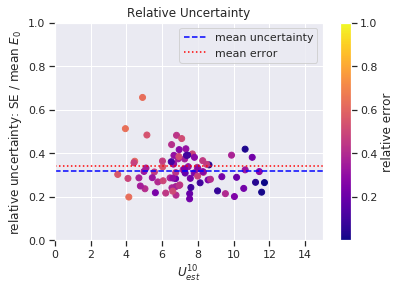

In [175]:
rel_error = np.abs((bulk_ds.u10est - bulk_ds.jra_wind) / bulk_ds.jra_wind)
plt.scatter(bulk_ds.u10est,bulk_ds.rmse_cut/bulk_ds.e0_mean,c=rel_error,cmap='plasma',vmax=1)
plt.axhline((bulk_ds.rmse_cut/bulk_ds.e0_mean).mean(),ls='--',c='b',label='mean uncertainty')
plt.axhline(rel_error.mean(),ls='dotted',c='r',label='mean absolute error')
plt.colorbar(label='relative error')
plt.ylabel('relative uncertainty: SE / mean $E_0$')
plt.xlabel(r'$U^{10}_{est}$')
plt.ylim(0,1)
plt.xlim(0,15)
plt.legend()
plt.title('Relative Uncertainty')
plt.show()

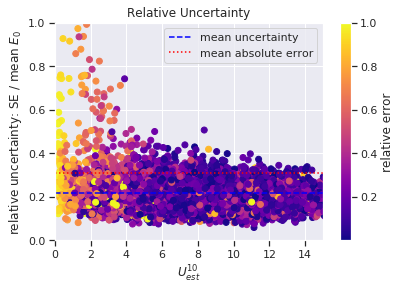

In [583]:
rel_error = np.abs((bulk_ds.u10est - bulk_ds.jra) / bulk_ds.jra)
plt.scatter(bulk_ds.u10est,bulk_ds.rmse_cut/bulk_ds.e0_mean,c=rel_error,cmap='plasma',vmax=1)
plt.axhline((bulk_ds.rmse_cut/bulk_ds.e0_mean).mean(),ls='--',c='b',label='mean uncertainty')
plt.axhline(rel_error.mean(),ls='dotted',c='r',label='mean absolute error')
plt.colorbar(label='relative error')
plt.ylabel('relative uncertainty: SE / mean $E_0$')
plt.xlabel(r'$U^{10}_{est}$')
plt.ylim(0,1)
plt.xlim(0,15)
plt.legend()
plt.title('Relative Uncertainty')
plt.show()

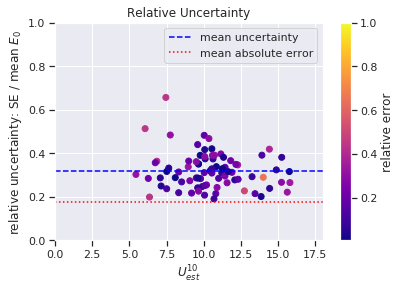

In [244]:
rel_error = np.abs((bulk_ds.u10est - bulk_ds.jra_wind) / bulk_ds.jra_wind)
plt.scatter(bulk_ds.u10est,bulk_ds.rmse_cut/bulk_ds.e0_mean,c=rel_error,cmap='plasma',vmax=1)
plt.axhline((bulk_ds.rmse_cut/bulk_ds.e0_mean).mean(),ls='--',c='b',label='mean uncertainty')
plt.axhline(rel_error.mean(),ls='dotted',c='r',label='mean absolute error')
plt.colorbar(label='relative error')
plt.ylabel('relative uncertainty: SE / mean $E_0$')
plt.xlabel(r'$U^{10}_{est}$')
plt.ylim(0,1)
plt.xlim(0,18)
plt.legend()
plt.title('Relative Uncertainty')
plt.show()

ValueError: 'c' argument has 9654 elements, which is not acceptable for use with 'x' with size 82, 'y' with size 82.

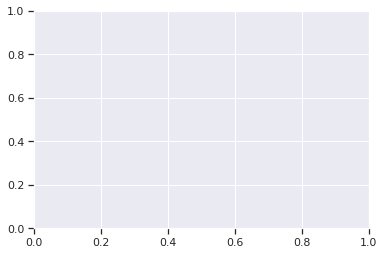

In [698]:
xx = np.linspace(4,15,100)
# plt.plot(u10_all,jra_all,marker='.',ls='')
plt.scatter(bulk_ds.u10est, bulk_ds.jra, c=rel_error, s=10, cmap='plasma')
plt.colorbar()
plt.plot(xx,xx*res.slope + res.intercept)
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

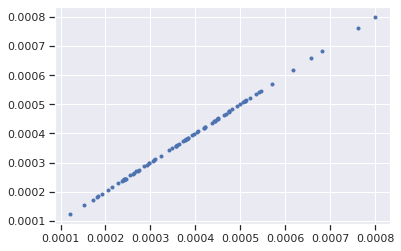

In [212]:
plt.plot(bulk_ds.rmsle_cut,bulk_ds.rmse_cut,ls='',marker='.')

ValueError: 'c' argument has 9654 elements, which is not acceptable for use with 'x' with size 84, 'y' with size 84.

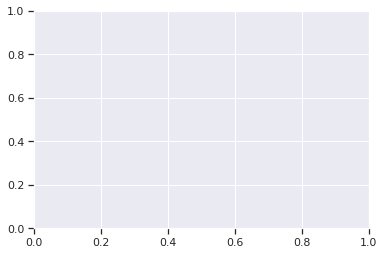

In [699]:
xx = np.linspace(4,15,100)
# plt.plot(u10_all,jra_all,marker='.',ls='')
plt.scatter(u10_all, jra_all, c=rel_error, s=10, cmap='plasma')
# plt.scatter(u10_all[cut_ind_90], jra_all[cut_ind_90], c=rmse_all[cut_ind_90], s=10, cmap='plasma',vmax=0.0009)
plt.colorbar()
plt.plot(xx,xx*res.slope + res.intercept)
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

In [700]:
cut_ind = np.argsort(bulk_ds.rmsle_cut.values)[0:int(len(bulk_ds.rmsle_cut))]
cut_ind_90 = np.argsort(bulk_ds.rmsle_cut.values)[0:int(len(bulk_ds.rmsle_cut)*0.90)]

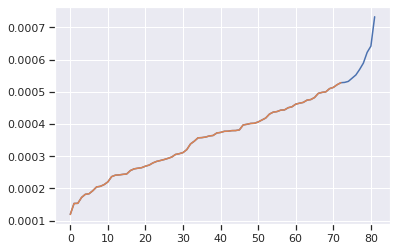

In [701]:
plt.plot(bulk_ds.rmsle_cut[cut_ind])
plt.plot(bulk_ds.rmsle_cut[cut_ind_90])

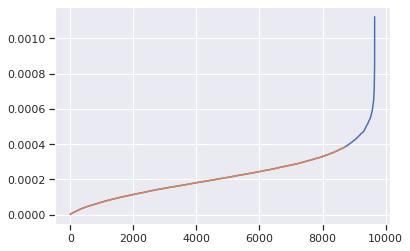

In [585]:
plt.plot(bulk_ds.rmsle_cut[cut_ind])
plt.plot(bulk_ds.rmsle_cut[cut_ind_90])
# plt.axhline(np.log(10**-1.6)

In [586]:
bulk_ds.rmse_cut[cut_ind][-10]

<xarray.DataArray 'rmse_cut' ()>
array(0.00075675)
Coordinates:
    obname   object 'bgosA'
    time     datetime64[ns] 2012-09-07T18:31:01
    TLON     float32 209.68408
    TLAT     float32 74.69676

In [647]:
inspec.rmsle_cut

<xarray.DataArray 'rmsle_cut' (time: 2)>
array([5.02179303e-06, 5.34515591e-06])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-01T12:00:00 2018-10-02T02:00:00
    TLON     (time) float32 211.24156 211.24156
    TLAT     (time) float32 73.13759 73.13759

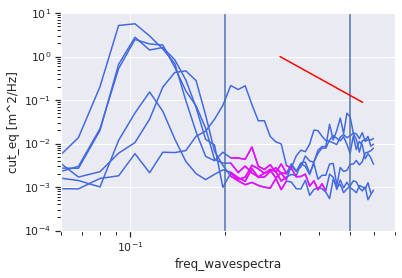

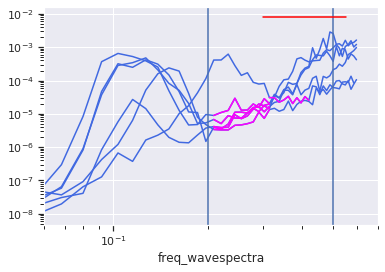

In [664]:
# temp = bulk_ds.u10est[cut_ind[-50:]]
temp = bulk_ds.u10est[cut_ind[0:50]]
obsel = 'sodaB'
temp = temp.where(temp.obname == obsel,drop=True).time

# inspec = spec_d['bgosD'].sel(time=bulk_ds.u10est[cut_ind][-7].time)
# inspec = spec_d['bgosA'].sel(time=bulk_ds.u10est[cut_ind][10].time)
inspec= spec_d[obsel].sel(time=temp)
          
inspec.wavespectra_energy.plot.line(hue='time',add_legend=False,c='royalblue')
inspec.cut_eq.plot.line(hue='time',add_legend=False,c='magenta')
plt.loglog()
plt.axvline(0.5)
plt.axvline(0.2)
plt.plot(Ax,Ay,c='r')
plt.xlim(0.06,0.7)
plt.ylim(10**-4,10)
plt.show()

(inspec.wavespectra_energy * inspec.freq_wavespectra**4).plot.line(hue='time',add_legend=False,c='royalblue')
(inspec.cut_eq * inspec.freq_wavespectra**4).plot.line(hue='time',add_legend=False,c='magenta')
plt.loglog()
plt.axvline(0.5)
plt.axvline(0.2)
plt.plot(Ax,Ay * Ax**4,c='r')
plt.xlim(0.06,0.7)
plt.show()

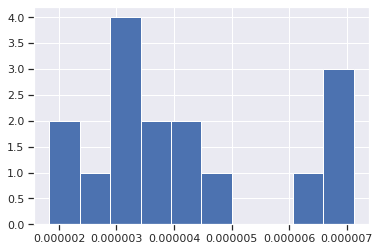

In [658]:
plt.hist(inspec.rmse_cut)
plt.show()

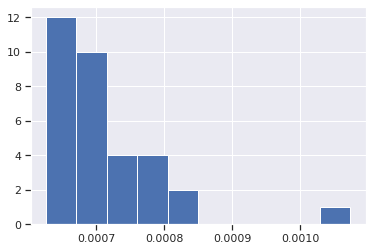

In [656]:
plt.hist(inspec.rmse_cut)
plt.show()

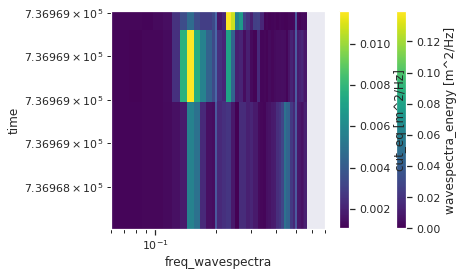

IndexError: index -1 is out of bounds for axis 0 with size 0

In [621]:
# inspec = spec_d['bgosD'].sel(time=bulk_ds.u10est[cut_ind][-7].time)
# inspec = spec_d['bgosA'].sel(time=bulk_ds.u10est[cut_ind][10].time)
inspec= spec_d['sodaA']
          
inspec.wavespectra_energy.plot()
inspec.cut_eq.plot()
plt.loglog()
plt.axvline(0.5)
plt.axvline(0.2)
plt.plot(Ax,Ay,c='r')
plt.xlim(0.06,0.7)
plt.show()

(inspec.wavespectra_energy * spec.freq_wavespectra**4).plot()
(inspec.cut_eq * spec.freq_wavespectra**4).plot()
plt.loglog()
plt.axvline(0.4)
plt.axvline(0.2)
plt.plot(Ax,Ay * Ax**4,c='r')
plt.xlim(0.06,0.7)
plt.show()

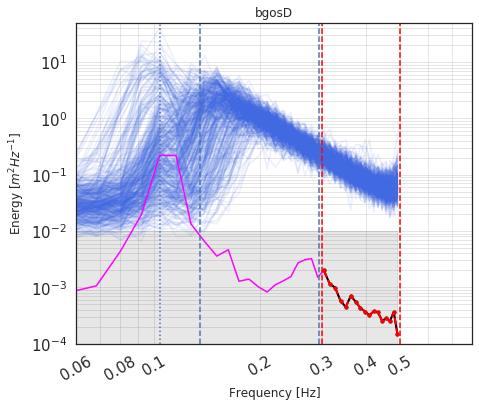

In [255]:
obkey = 'bgosD'
spec = spec_d_open[obkey]
time_isel = 10
spec_sel = spec.sel(time=bulk_ds.u10est[cut_ind][1].time.values)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod
ef_eq = spec.ef_eq

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.where(spec.u10est > 12).plot.line(
        hue='time',alpha=0.1,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')
    
    ## selected spectra
    spec_sel.wavespectra_energy.plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    
    ef_eq.sel(time=bulk_ds.u10est[cut_ind][1].time.values).plot(xscale='log',yscale='log',
        c='k',lw=2,marker='.')
    spec_sel.cut_eq.plot(xscale='log',yscale='log',
        c='r',lw=2,marker='.',ls='--')
#     ef_eq[0].where(ef_eq.freq_wavespectra < tempefeq[0][critf[0]]).plot(xscale='log',yscale='log',
#         c='b',lw=2,marker='.')
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='dotted')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.plot(xx,yy,label='$f^{-4}$',lw=3,c='b')
#     plt.legend()
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.8)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(obkey)
    
    fig.tight_layout()
    plt.show()

In [259]:
(~np.isnan(spec_sel.freq_wavespectra.where(spec_sel.freq_wavespectra > 0.3))).sum()

<xarray.DataArray 'freq_wavespectra' ()>
array(17)
Coordinates:
    time     datetime64[ns] 2015-09-02T01:31:01
    TLON     float32 219.82047
    TLAT     float32 73.84869

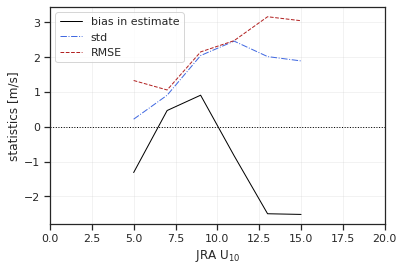

In [711]:
with sns.axes_style('ticks'):
    bins = np.arange(0,20,2)
    bulk_ds['err_sq'] = bulk_ds.err**2
    gbins = bulk_ds.groupby_bins('jra',bins=bins)

    gbins.mean().err.plot(c='k',lw=1,label='bias in estimate')

    gbins.std().u10est.plot(c='royalblue',ls='-.',lw=1,label='std')

    ((gbins.mean().err_sq)**0.5).plot(c='firebrick',ls='--',lw=1,label='RMSE')


    plt.grid(alpha=0.25)
    plt.axhline(0,lw=1,c='k',ls='dotted')
    plt.legend()
    plt.xlim(0,20)
    plt.xlabel('JRA U$_{10}$')
    plt.ylabel('statistics [m/s]')
    # plt.scatter(bulk_ds.u10est,bulk_ds.err)
    plt.show()

In [69]:
bulk_ds['err'] = bulk_ds.u10est - bulk_ds.jra

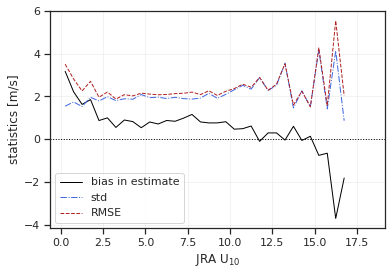

In [687]:
with sns.axes_style('ticks'):
#     bins = np.arange(7,17.1,2)
    bins = np.arange(0,20,0.5)
    bulk_ds['err_sq'] = bulk_ds.err**2
    gbins = bulk_ds.groupby_bins('jra',bins=bins)

    gbins.mean().err.plot(c='k',lw=1,label='bias in estimate')

    gbins.std().u10est.plot(c='royalblue',ls='-.',lw=1,label='std')

    ((gbins.mean().err_sq)**0.5).plot(c='firebrick',ls='--',lw=1,label='RMSE')


    plt.grid(alpha=0.25)
    plt.axhline(0,lw=1,c='k',ls='dotted')
    plt.legend()
#     plt.xlim(8,16)
    plt.xlabel('JRA U$_{10}$')
    plt.ylabel('statistics [m/s]')
    # plt.scatter(bulk_ds.u10est,bulk_ds.err)
    plt.show()

### older version individual obs

In [156]:
ob_sel = 'bgosA'
obs_ds = insitu_dict[ob_sel]
setmin = 0.3
dmin = 100
dmax = 1e6

## constants
Ip = 1.9 # Voermans 1.9 to 3.1 (wide to narrow), 2.5 works (Thomson 2013)
vk = 0.41 # von karman constant
beta = 0.012 #(Juszko 1995)
alpha = 0.012 # Charnock 1955
g = 9.81

spec = obs_ds.where(
    (obs_ds.sigwaveheight > 0.3) & (obs_ds.cdr > dmin) & (obs_ds.cdr < dmax),drop=True)

In [157]:
templat = obs_ds.lat.values.mean()
templon = obs_ds.lon.values.mean() % 360

difflat = templat - jra_subset.latitude.values
difflon = templon - jra_subset.longitude.values
dlat,dlon = np.meshgrid(difflat,difflon)
dist = dlat**2 + dlon**2

lon_isel = np.where(dist == np.min(dist))[0][0]
lat_isel = np.where(dist == np.min(dist))[1][0]

In [158]:
jra_obstime = jra_subset.time.indexes['time'].to_datetimeindex().to_numpy()
jra_time_isel = np.searchsorted(jra_obstime,obs_ds.time)
obs_ds['jra_wind'] = ('time',
                      jra_subset.isel(time=jra_time_isel,latitude=lat_isel,longitude=lon_isel).wind.values)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


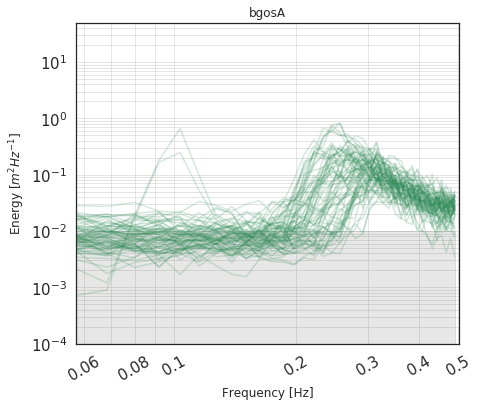

In [159]:
with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.plot.line(
        hue='time',alpha=0.2,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(ob_sel)
    
    fig.tight_layout()
    plt.show()

## Follow Voermans et al 2020, Thomson OS P 2013
- Now I am going to calculate the wind speed and compare to reanalysis

In [160]:
## constants
Ip = 1.9 # Voermans 1.9 to 3.1 (wide to narrow), 2.5 works (Thomson 2013)
vk = 0.41 # von karman constant
beta = 0.012 #(Juszko 1995)
alpha = 0.012 # Charnock 1955
g = 9.81

In [161]:
spec['fp'] = ('time',1/spec.peakwaveperiod)
ef_eq = spec.wavespectra_energy.where(
    (spec.freq_wavespectra > spec.fp) & 
    (spec.freq_wavespectra > 0.3))

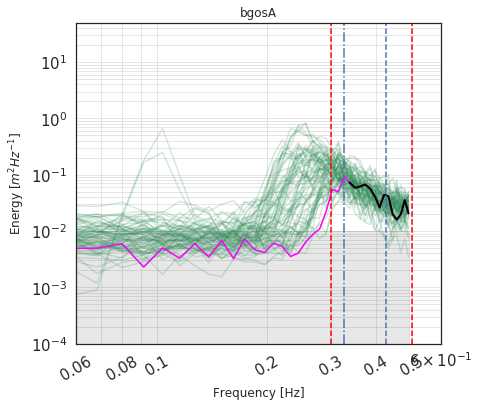

In [162]:
time_isel = 0
spec_sel = spec.isel(time=time_isel)
spec_sel['fp'] = 1/spec_sel.peakwaveperiod

with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    spec.wavespectra_energy.plot.line(
        hue='time',alpha=0.2,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')
    
    ## selected spectra
    spec_sel.wavespectra_energy.plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    
    ef_eq.isel(time=time_isel).plot(xscale='log',yscale='log',
        c='k',lw=2)
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='-.')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
        
    ### NOISE FLOOR
    x = spec.freq_wavespectra.values
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    
    
    ax.grid(True,which='both',alpha=0.5)
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),5*10**(1))
    plt.xlim(0.06,0.6)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(ob_sel)
    
    fig.tight_layout()
    plt.show()

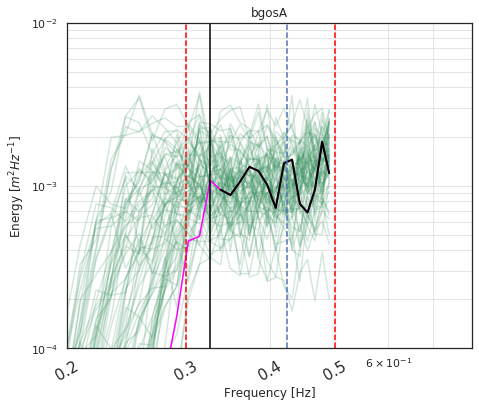

In [163]:
with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(7,6))
    
    (spec.wavespectra_energy*spec.freq_wavespectra**(4)).plot.line(
        hue='time',alpha=0.2,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')
    
    ## selected spectra
    (spec_sel.wavespectra_energy*spec.freq_wavespectra**(4)).plot(alpha=0.99,
        xscale='log',yscale='log',
        c='magenta')
    (ef_eq.isel(time=time_isel)*spec.freq_wavespectra**(4)).plot(xscale='log',yscale='log',
        c='k',lw=2)
    
    fp = spec_sel.peakwaveperiod**(-1)
    plt.axvline(fp,ls='-',c='k')
    plt.axvline(fp*1.3,ls='--')
    plt.axvline(fp*2*2**(0.5),ls='--')
    plt.axvline(0.3,ls='--',c='r')
    plt.axvline(0.5,ls='--',c='r')
    
    ax.grid(True,which='both',alpha=0.5)
    
    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str),fontsize='small',rotation=30)
    plt.ylim(10**(-4),10**(-2))
    plt.xlim(0.2,0.8)
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')
    plt.xlabel('Frequency [Hz]')
    plt.title(ob_sel)
    
    fig.tight_layout()
    plt.show()

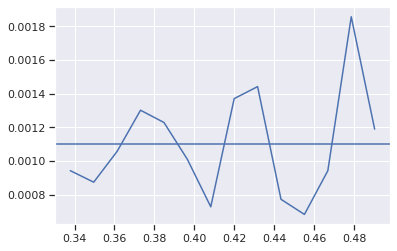

In [164]:
ef_eq_isel = ef_eq.isel(time=time_isel)
plt.plot(ef_eq_isel.freq_wavespectra,ef_eq_isel * ef_eq_isel.freq_wavespectra**4)
e0_mean = (ef_eq_isel * ef_eq_isel.freq_wavespectra**4).mean()
plt.axhline(e0_mean)

In [165]:
spec['e0_mean'] = (ef_eq * ef_eq.freq_wavespectra**4).mean(dim='freq_wavespectra')

In [216]:
# print(e0_mean.values)
spec['e0_mean'] = (ef_eq * ef_eq.freq_wavespectra**4).mean(dim='freq_wavespectra')
ustar = spec.e0_mean * (2*np.pi)**3 / (4 * beta * Ip * g)
z0 = alpha * ustar**2 / g # + 0.11 * nu / ustar (roughness length, ignoring first term)
u10est = ustar/vk * np.log(10 / z0)

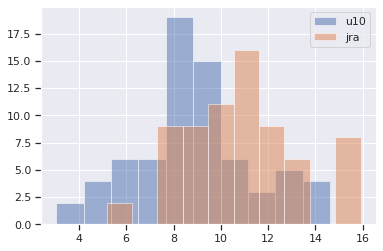

In [218]:
plt.hist(u10est,alpha=0.5,label='u10')
plt.hist(obs_ds.jra_wind.sel(time=u10est.time),alpha=0.5,label='jra')
plt.legend()
plt.show()

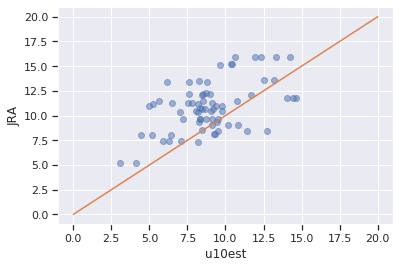

In [220]:
plt.plot(u10est,obs_ds.jra_wind.sel(time=u10est.time),marker='o',ls='',alpha=0.5)
plt.plot(np.linspace(0,20,10),np.linspace(0,20,10))
plt.xlabel('u10est')
plt.ylabel('JRA')
plt.show()

<xarray.DataArray ()>
array(-1.93306025)


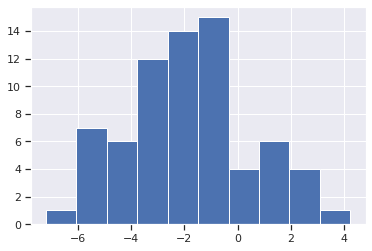

In [221]:
print((u10est - obs_ds.jra_wind.sel(time=u10est.time)).mean())
plt.hist(u10est - obs_ds.jra_wind.sel(time=u10est.time))
plt.show()

In [222]:
df = pd.DataFrame(data={'u10est':u10est,'jra':obs_ds.jra_wind.sel(time=u10est.time)})

In [223]:
from sklearn.linear_model import LinearRegression


Model slope:     0.5287437734508501
Model intercept: 6.153049405511399


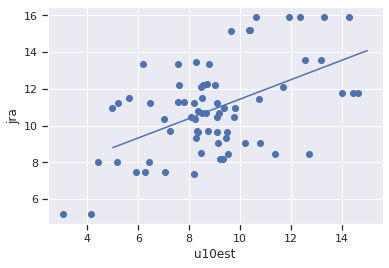

In [247]:
model = LinearRegression(fit_intercept=True,normalize=False)
x = df.u10est
y = df.jra
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(5, 15, 100)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlabel('u10est')
plt.ylabel('jra')

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)


In [248]:
model.score(x[:, np.newaxis], y)

0.2741160686291172

In [255]:
# import scipy.stats as stats
stats.linregress(x,y)

LinregressResult(slope=0.5287437734508501, intercept=6.153049289708089, rvalue=0.5235609631855412, pvalue=3.3072354318234394e-06, stderr=0.10434151519834436)

In [214]:
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                    jra   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     25.68
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           3.31e-06
Time:                        20:48:16   Log-Likelihood:                -152.05
No. Observations:                  70   AIC:                             308.1
Df Residuals:                      68   BIC:                             312.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1530      0.969      6.349      0.0

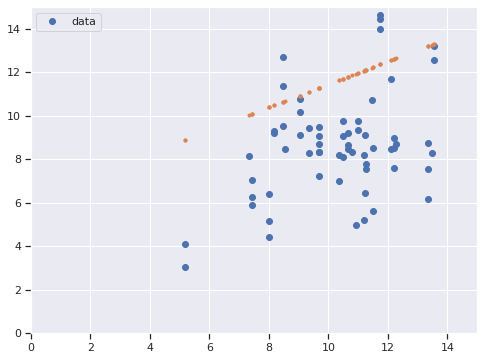

In [215]:
y = df.u10est
x = df.jra

# pred_ols = linreg.get_prediction()
# iv_l = pred_ols.summary_frame()["obs_ci_lower"]
# iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
# ax.plot(x, y_true, "b-", label="True")
# ax.plot(x, linreg.fittedvalues, "r.", label="OLS")
ax.plot(x,linreg.params.Intercept + linreg.params.u10est * x,ls='',marker='.')
# ax.plot(x, iv_u, "r--")
# ax.plot(x, iv_l, "r--")
ax.legend(loc="best")
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

In [198]:
sns.regplot()

TypeError: regplot() missing 2 required positional arguments: 'x' and 'y'

In [199]:
linreg.fittedvalues

0      8.905963
1     10.815016
2     10.815016
3     10.815016
4     10.251142
        ...    
65    12.852992
66    11.130574
67    11.838908
68     6.915436
69     6.915436
Length: 70, dtype: float64

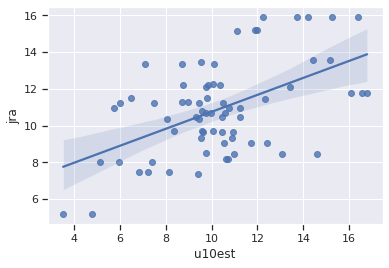

In [200]:
sns.regplot(df.u10est,df.jra)